<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
path_to_evm_label="/content/expo_moving_labels.csv"
path_to_app="/content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
ewm_df_status=pd.read_csv(path_to_evm_label,index_col=0)

In [3]:
labels_to_int_evm={"bad":1,"neutral":2,"good":2}

In [4]:
ewm_df=ewm_df_status.drop(columns="status").replace({"label":labels_to_int_evm})

In [5]:
dep_var="label"
random_state=42

In [6]:
from sklearn.model_selection import ShuffleSplit
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from fastai.tabular.all import *
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [34]:
train_df=ewm_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [35]:
cont,cat = cont_cat_split(train_df, max_card=1, dep_var=dep_var)

In [36]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [37]:
procs = [Categorify, Normalize]
to = TabularPandas(train_df, procs, cat, cont,
                      splits=splits, y_names=dep_var)

In [38]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [39]:
Counter(valid_y)

Counter({1: 384, 2: 1129})

In [40]:
m = DecisionTreeClassifier(max_depth=18,random_state=random_state)
m.fit(xs, y)

DecisionTreeClassifier(max_depth=18, random_state=42)

In [41]:
preds=m.predict(valid_xs)

In [42]:
int_to_labels_evm={"bad":1,"good":2}
#int_to_labels_evm={v:k for k,v in enumerate(labels_to_int_evm)}

              precision    recall  f1-score   support

         bad       0.24      0.18      0.21       384
        good       0.74      0.81      0.77      1129

    accuracy                           0.65      1513
   macro avg       0.49      0.49      0.49      1513
weighted avg       0.61      0.65      0.63      1513



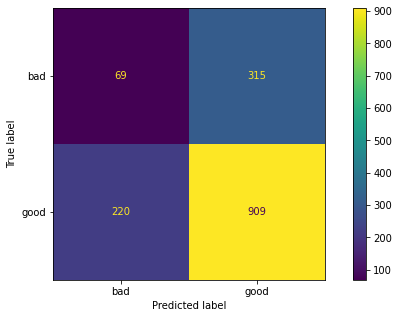

In [50]:
print(classification_report(valid_y, preds,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y, preds,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [20]:
def rf(xs, y, n_estimators=40, max_samples=4000,
       max_features=0.5, min_samples_leaf=5,random_state=random_state):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,random_state=random_state).fit(xs, y)

In [21]:
rf_m = rf(xs, y)
preds_rf=rf_m.predict(valid_xs)

In [27]:
Counter(valid_y)

Counter({2: 1169, 1: 344})

              precision    recall  f1-score   support

         bad       0.29      0.01      0.02       384
        good       0.75      0.99      0.85      1129

    accuracy                           0.74      1513
   macro avg       0.52      0.50      0.44      1513
weighted avg       0.63      0.74      0.64      1513



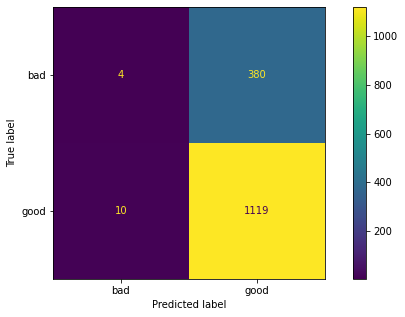

In [47]:
print(classification_report(valid_y,preds_rf,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y,preds_rf,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [23]:
from lightgbm import LGBMClassifier,plot_importance

In [32]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(xs,y)

LGBMClassifier(random_state=42)

              precision    recall  f1-score   support

         bad       0.85      0.17      0.29       384
        good       0.78      0.99      0.87      1129

    accuracy                           0.78      1513
   macro avg       0.81      0.58      0.58      1513
weighted avg       0.80      0.78      0.72      1513



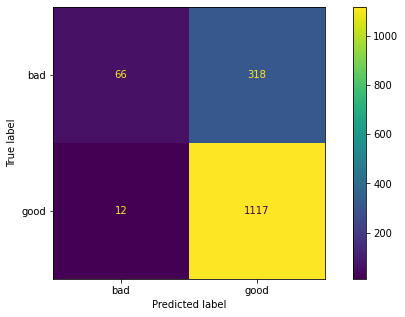

In [52]:
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(valid_y,pred_boost,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y,pred_boost,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

We need to max precision of bad value, boosted tree good!

Feature importance

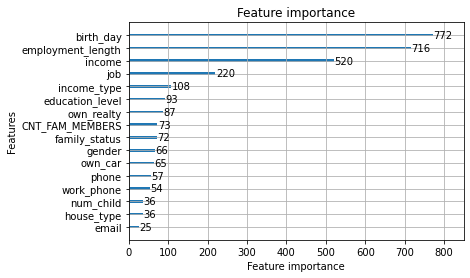

In [53]:
plot_importance(boosted_tree)

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [54]:
import imblearn

In [55]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [56]:
procs = [Categorify, Normalize]
cont,cat = cont_cat_split(train_df, max_card=1,dep_var=dep_var)
to = TabularPandas(train_df, procs, cat, cont,
                      splits=splits,y_names=dep_var)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [57]:
xs["label"]=y
class_1=xs[y==1]
class_2=xs[y==2]
class_count_2, class_count_1 = y.value_counts()
print('class 2:', class_2.shape)
print('class 1:', class_1.shape)
class_2_under = class_2.sample(class_count_1)
test_under = pd.concat([class_2_under, class_1], axis=0)
y=test_under["label"]
xs=test_under.drop("label",axis=1)

class 2: (4475, 17)
class 1: (1575, 17)


              precision    recall  f1-score   support

         bad       0.25      0.51      0.34       367
        good       0.77      0.52      0.62      1146

    accuracy                           0.51      1513
   macro avg       0.51      0.51      0.48      1513
weighted avg       0.64      0.51      0.55      1513



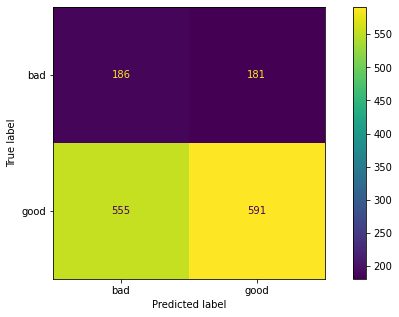

In [58]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(xs,y)
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(valid_y,pred_boost,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y,pred_boost,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [59]:
from imblearn.under_sampling import TomekLinks

In [60]:
tl = TomekLinks()
X_res, y_res=tl.fit_resample(xs, y)

              precision    recall  f1-score   support

         bad       0.24      0.68      0.36       367
        good       0.76      0.32      0.45      1146

    accuracy                           0.41      1513
   macro avg       0.50      0.50      0.40      1513
weighted avg       0.63      0.41      0.43      1513



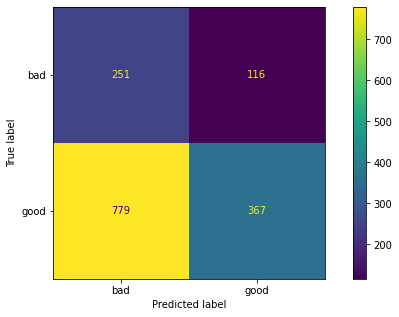

In [65]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(X_res,y_res)
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(valid_y,pred_boost,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y,pred_boost,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [63]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(xs, y)
print(x_smote.shape)

(3150, 16)


              precision    recall  f1-score   support

         bad       0.25      0.51      0.34       367
        good       0.77      0.52      0.62      1146

    accuracy                           0.51      1513
   macro avg       0.51      0.51      0.48      1513
weighted avg       0.64      0.51      0.55      1513



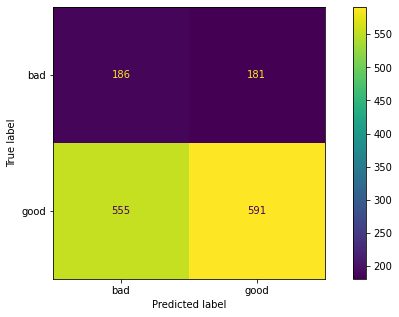

In [64]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(x_smote,y_smote)
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(valid_y,pred_boost,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y,pred_boost,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [62]:
from sklearn.svm import SVC

In [66]:
svc_model = SVC(class_weight='balanced', probability=True)
svc_model.fit(xs, y)

SVC(class_weight='balanced', probability=True)

              precision    recall  f1-score   support

         bad       0.25      0.56      0.34       367
        good       0.76      0.45      0.57      1146

    accuracy                           0.48      1513
   macro avg       0.50      0.50      0.45      1513
weighted avg       0.64      0.48      0.51      1513



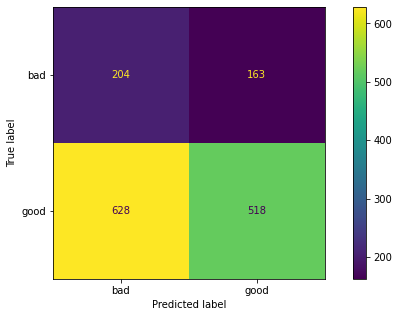

In [67]:
svc_predict = svc_model.predict(valid_xs)# check performance
print(classification_report(valid_y,svc_predict,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(valid_y,svc_predict,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 